# Sky Brightness in LSST

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import astropy.units as u

## Read Opsim Cadence

See opsim db [summary table docs](http://lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335).

In [4]:
import sqlite3

In [49]:
import astropy.table

In [5]:
conn = sqlite3.connect('/Data/DESC/minion_1016_sqlite.db')

In [6]:
c = conn.cursor()

Fetch 1000 rows of r-band observations.

In [50]:
c.execute("""SELECT airmass,dist2Moon,moonAlt,moonPhase,filtSkyBrightness
             FROM summary WHERE filter = 'r' LIMIT 1000""")
opsim = astropy.table.Table(
    np.array(c.fetchall()),
    names=('airmass', 'dist2Moon', 'moonAlt', 'moonPhase','filtSkyBrightness'))

In [ ]:
conn.close()

## Predict Sky Brightness

See [specsim atmosphere docs](http://specsim.readthedocs.org/en/latest/config.html#atmosphere)
and [speclite filter docs](http://speclite.readthedocs.org/en/latest/filters.html). The moon's contribution to the sky brightness is calculated using Based on Krisciunas and Schaefer, “A model of the brightness of moonlight”, PASP, vol. 103, Sept. 1991, p. 1033-1039.

In [3]:
import speclite.filters

In [8]:
import specsim.atmosphere
import specsim.config

In [9]:
cfg = specsim.config.load_config('desi')
atm = specsim.atmosphere.initialize(cfg)

In [31]:
def predict(airmass, dist_to_moon, moon_altitude, moon_illumination, filter_name='sdss2010-r'):
    """Predict the sky brightness 
    
    Parameters
    ----------
    airmass : float
        Airmass at the field center of the visit.
    dist_to_moon : float
        Distance from the field center to the moon's center on the sky, in radians.
    moon_altitude : float
        Altitude of the Moon taking into account the elevation of the site, in radians.
    moon_illumination : float
        Percent illumination of the Moon (0=new, 100=full).
    filter_name : str
        Name of the filter to use for calculating the sky brightness.
        
    Returns
    -------
    float
        AB magnitude of the sky in the specified filter.
    """
    
    atm.airmass = airmass
    atm.moon.moon_zenith = (np.pi / 2 - moon_altitude) * u.rad
    atm.moon.separation_angle = dist_to_moon * u.rad
    # Convert illumination percentage to temporal phase in the range [0,1]
    # with 0 = full moon, 1 = new moon.
    atm.moon.moon_phase = np.arccos(2 * (moon_illumination / 100.) - 1) / np.pi
    
    filt = speclite.filters.load_filter(filter_name)
    wlen = cfg.wavelength
    return filt.get_ab_magnitude(atm.surface_brightness * u.arcsec ** 2, wlen)

## Compare OpSim with SpecSim

In [51]:
r_predicted = []
for obs in opsim:
    r_predicted.append(predict(obs['airmass'], obs['dist2Moon'], obs['moonAlt'], obs['moonPhase']))
r_predicted = np.array(r_predicted)

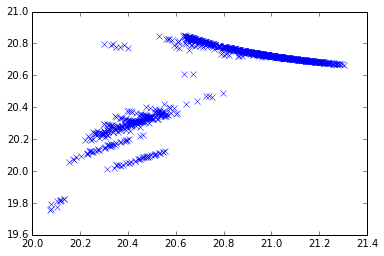

In [54]:
plt.plot(opsim['filtSkyBrightness'], r_predicted, 'x')
plt.xlim(20, 21.4);

Hmm, I was expecting better agreement.  It looks like there are subsets of observations with tight correlations.  What opsim parameters define these different subsets?  Try coloring points using additional opsim vars.

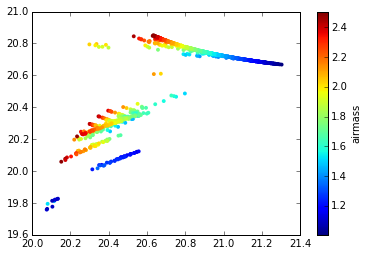

In [66]:
plt.scatter(opsim['filtSkyBrightness'], r_predicted, lw=0., s=15., c=opsim['airmass'])
plt.colorbar().set_label('airmass')
plt.xlim(20, 21.4);

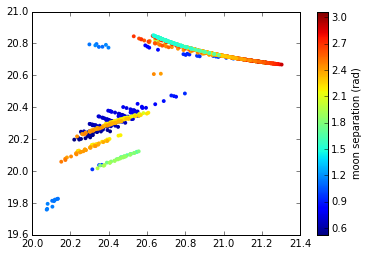

In [65]:
plt.scatter(opsim['filtSkyBrightness'], r_predicted, lw=0., s=15., c=opsim['dist2Moon'])
plt.colorbar().set_label('moon separation (rad)')
plt.xlim(20, 21.4);

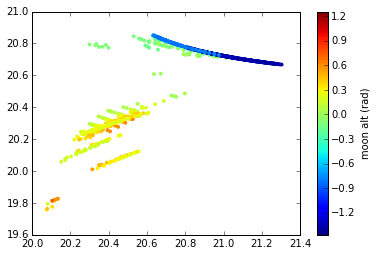

In [64]:
plt.scatter(opsim['filtSkyBrightness'], r_predicted, lw=0., s=15., c=opsim['moonAlt'])
plt.colorbar().set_label('moon alt (rad)')
plt.xlim(20, 21.4);

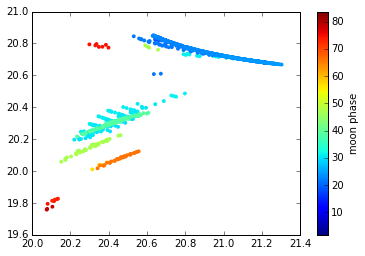

In [62]:
plt.scatter(opsim['filtSkyBrightness'], r_predicted, lw=0., s=15., c=opsim['moonPhase'])
plt.colorbar().set_label('moon phase')
plt.xlim(20, 21.4);

It looks like the moon phase is the best predictor of discrepancies between specsim and opsim.